In [8]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))


import jax.numpy as jnp
import optax

from bde.bde import BDE

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [9]:
data = fetch_openml(name="airfoil_self_noise", as_frame=True)

X = data.data.values   # shape (1503, 5)
y = data.target.values.reshape(-1, 1)  # shape (1503, 1)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

Xmu, Xstd = jnp.mean(X_train, 0), jnp.std(X_train, 0) + 1e-8
Ymu, Ystd = jnp.mean(y_train, 0), jnp.std(y_train, 0) + 1e-8

Xtr = (X_train - Xmu) / Xstd
Xte = (X_test  - Xmu) / Xstd
ytr = (y_train - Ymu) / Ystd
yte = (y_test  - Ymu) / Ystd

sizes = [5, 16, 16, 2]

/home/vyron/miniconda3/envs/bde/lib/python3.12/site-packages/sklearn/datasets/_openml.py:320: UserWarning: Multiple active versions of the dataset matching the name airfoil_self_noise exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43919
- version 8, status: active
  url: https://www.openml.org/search?type=data&id=44957

  warn(warning_msg)


In [10]:
bde = BDE(
        n_members=6, 
        sizes=sizes,
        seed=0
        )

bde.train(
        X=Xtr, 
        y=ytr, 
        epochs=1000,
        lr=1e-3,
        warmup_steps=100,
        n_samples=5000,
        n_thinning=10,
        )

means, sigmas = bde.evaluate(Xte)

0 1.763954520225525
100 1.0640883445739746
200 0.7785029411315918
300 0.5714554786682129
400 0.4191734790802002
500 0.31694069504737854
600 0.2391066551208496
700 0.17081758379936218
800 0.11076229810714722
900 0.0606042854487896
---Initialize warmup---
---Search for optimal Parameters---
Initial L:  20.049938
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=-0.000732421875
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=-0.0003662109375
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=6.103515625e-05
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=-6.103515625e-05
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=0.0001220703125
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=-6.103515625e-05
step 1 | ok=True | step_size=0.020711442455649376 | cap=3.4028234663852886e+38 

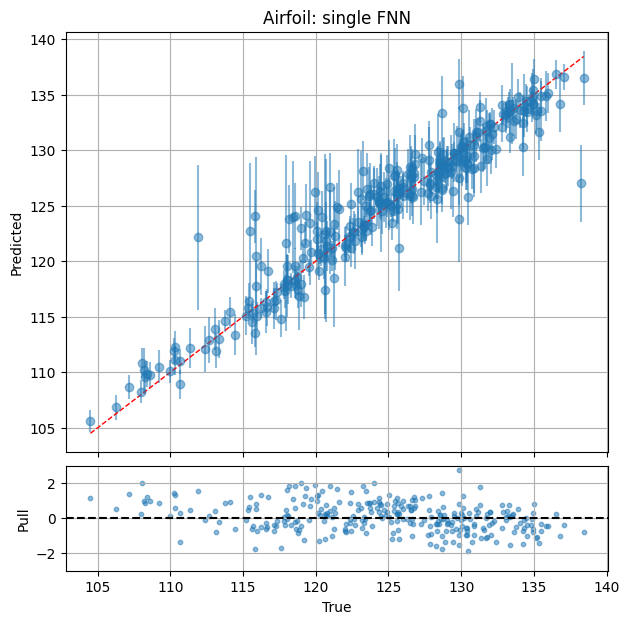

In [11]:
y_pred_sampled = means * Ystd + Ymu
y_err_sampled  = sigmas * Ystd
y_true = yte * Ystd + Ymu

yt = np.asarray(y_true).ravel()
yp_sampled = np.asarray(y_pred_sampled).ravel()
ye_sampled = np.asarray(y_err_sampled).ravel()
ye_sampled = np.maximum(ye_sampled, 1e-8)  # guard

fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(2,1, height_ratios=[4,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.errorbar(yt, yp_sampled, yerr=ye_sampled, fmt='o', alpha=0.5)
m, M = float(min(yt.min(), yp_sampled.min())), float(max(yt.max(), yp_sampled.max()))
ax.plot([m,M],[m,M], 'r--', lw=1)
ax.set_ylabel("Predicted"); ax.set_title("Airfoil: single FNN"); ax.grid(True)
plt.setp(ax.get_xticklabels(), visible=False)


ax2 = plt.subplot(gs[1], sharex=ax)
pull_sampled = (yp_sampled - yt) / ye_sampled
ax2.axhline(0, color='k', ls='--')
ax2.scatter(yt, pull_sampled, s=10, alpha=0.5)
ax2.set_xlabel("True"); ax2.set_ylabel("Pull"); ax2.set_ylim(-3,3); ax2.grid(True)


In [12]:
import jax.numpy as jnp

def coverage_count(y_true, mu, sigma, k=1):
    sigma = jnp.maximum(sigma, 1e-8)
    mask = jnp.abs(y_true - mu) <= k * sigma   # True if within k·σ
    return int(jnp.count_nonzero(mask)), float(jnp.mean(mask))

# examples:
# mu, sigma, y_true all shape (N,)
count_1, frac_1 = coverage_count(yt, yp_sampled, ye_sampled, k=1)
count_2, frac_2 = coverage_count(yt, yp_sampled, ye_sampled, k=2)
count_3, frac_3 = coverage_count(yt, yp_sampled, ye_sampled, k=3)

#print(frac_1, frac_2, frac_3)
print(jnp.sqrt(jnp.mean((yp_sampled - yt)**2))) 

2.1259406
